In [2]:
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ["../fonts"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams["font.family"] = "umr10"
rcParams["font.size"] = 16

In [3]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
bikes_df = pd.read_csv("../dataset/processed/processed_dataset.csv")

### Podstawowe parametry danych

In [4]:
# ile wierszy i kolumn
bikes_df.shape

(4491474, 7)

In [5]:
# jakie kolumny
bikes_df.columns

Index(['uid', 'bike_number', 'start_time', 'end_time', 'rental_place',
       'return_place', 'duration'],
      dtype='object')

In [6]:
bikes_df.head(7)

,uid,bike_number,start_time,end_time,rental_place,return_place,duration
0,65533380,57114,2019-03-15 10:21:55,2019-03-15 10:28:18,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),6
1,65533368,57092,2019-03-15 10:21:32,2019-03-15 10:28:23,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),6
2,65533283,57060,2019-03-15 10:18:19,2019-03-15 10:32:18,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),13
3,65533213,57115,2019-03-15 10:15:20,2019-03-15 10:32:21,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),17
4,65533616,57114,2019-03-15 10:32:19,2019-03-15 10:34:08,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),1
5,65533654,57131,2019-03-15 10:34:16,2019-03-15 10:34:38,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),0
6,65533668,57115,2019-03-15 10:34:41,2019-03-15 10:36:05,Świdnicka / Piłsudskiego (Hotel Scandic),Świdnicka / Piłsudskiego (Hotel Scandic),1


In [7]:
# zakres czasu
min_time = (
    bikes_df["start_time"]
    .apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    .min()
)
max_time = (
    bikes_df["end_time"]
    .apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    .max()
)

print(f"Okres uwzględniony w danych:\n{min_time}  -  {max_time}")

Okres uwzględniony w danych:
2019-03-11 21:29:35  -  2021-12-31 23:58:36


In [8]:
# liczba różnych wartości dla rental_place i return_place
print(f'rental_place: {len(set(bikes_df["rental_place"]))} różnych wartości')
print(f'return_place: {len(set(bikes_df["return_place"]))} różnych wartości')
both = len(set.union(set(bikes_df["rental_place"]), set(bikes_df["return_place"])))
print(f"rental_place i return_place wspólnie: {both} różnych wartości")
rental_not_return = list(set(bikes_df["rental_place"]) - set(bikes_df["return_place"]))
print(f"W rental_place ale nie w return_place: {', '.join(rental_not_return)}")

rental_place: 216 różnych wartości
return_place: 216 różnych wartości
rental_place i return_place wspólnie: 216 różnych wartości
W rental_place ale nie w return_place: 


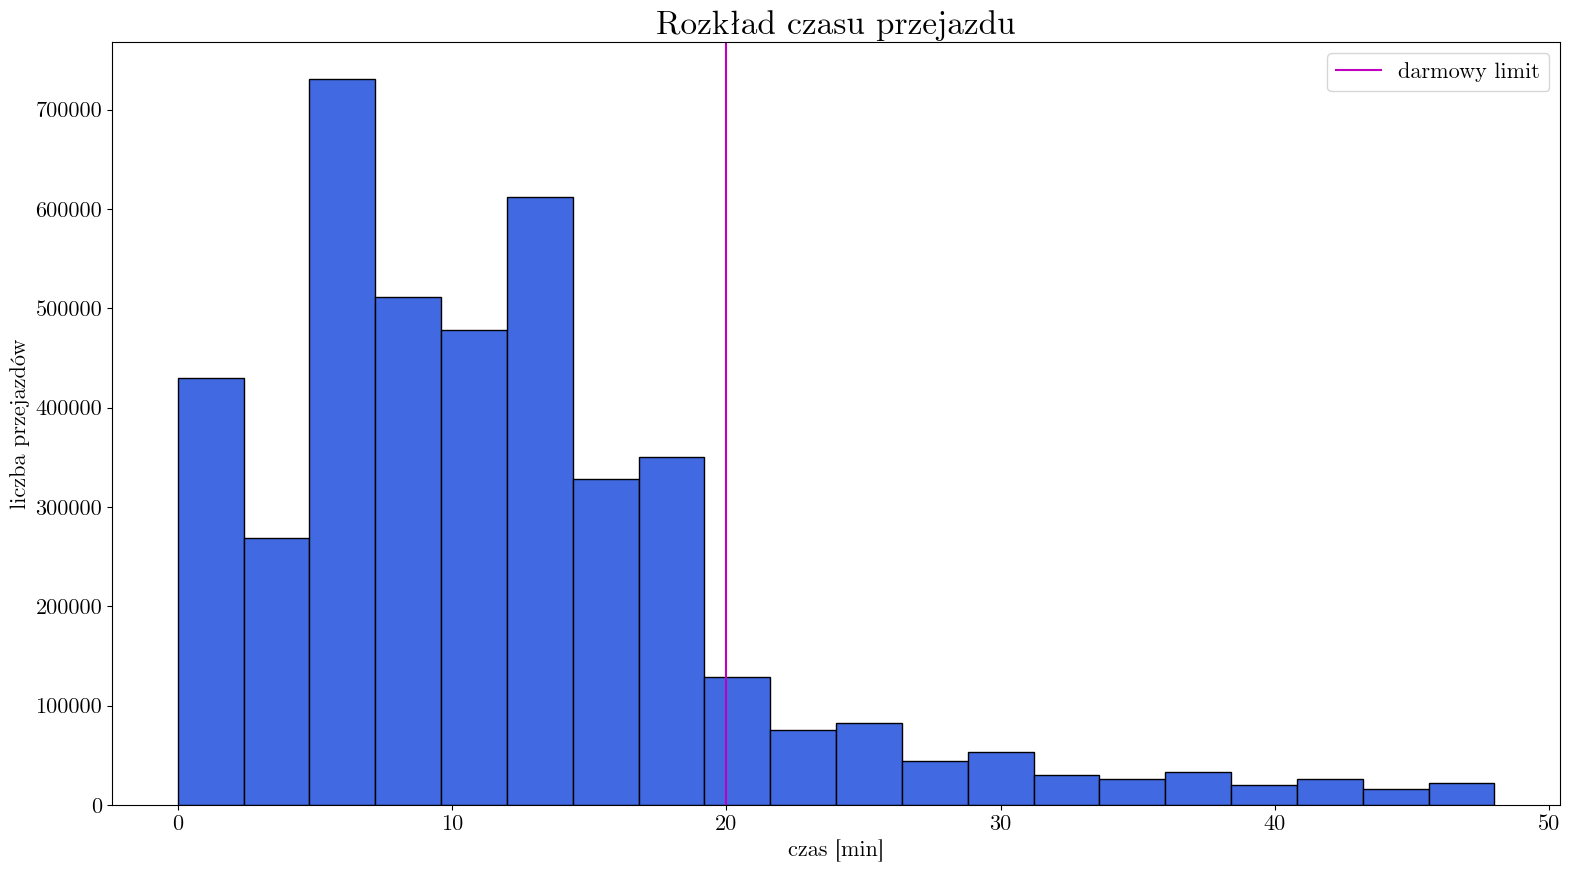

In [9]:
# rozkład czasu przejazdu (bez outlierów)

dur = bikes_df["duration"]
dur_no_outliers = dur[dur < dur.quantile(0.95)]

fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(dur_no_outliers, bins=20, color="royalblue", edgecolor="black")
ax.set_title("Rozkład czasu przejazdu", fontsize=24)
ax.set_xlabel("czas [min]")
ax.set_ylabel("liczba przejazdów")

# zaznaczamy granicę darmowego przejazdu 20 minut
ax.axvline(ymin=0, ymax=9e5, x=20, c="m", label="darmowy limit")

plt.tight_layout()
ax.legend()

plt.savefig(
    "../images/analysis/rozklad_czasu_przejazdu.png",
    bbox_inches="tight",
    dpi=400,
)

### Analizy per rower

In [10]:
bikes_durations_sums = (
    bikes_df.groupby(by="bike_number")["duration"].sum().sort_values()
)
bikes_durations_means = (
    bikes_df.groupby(by="bike_number")["duration"].mean().sort_values()
)
bikes_durations_counts = (
    bikes_df.groupby(by="bike_number")["duration"].count().sort_values()
)

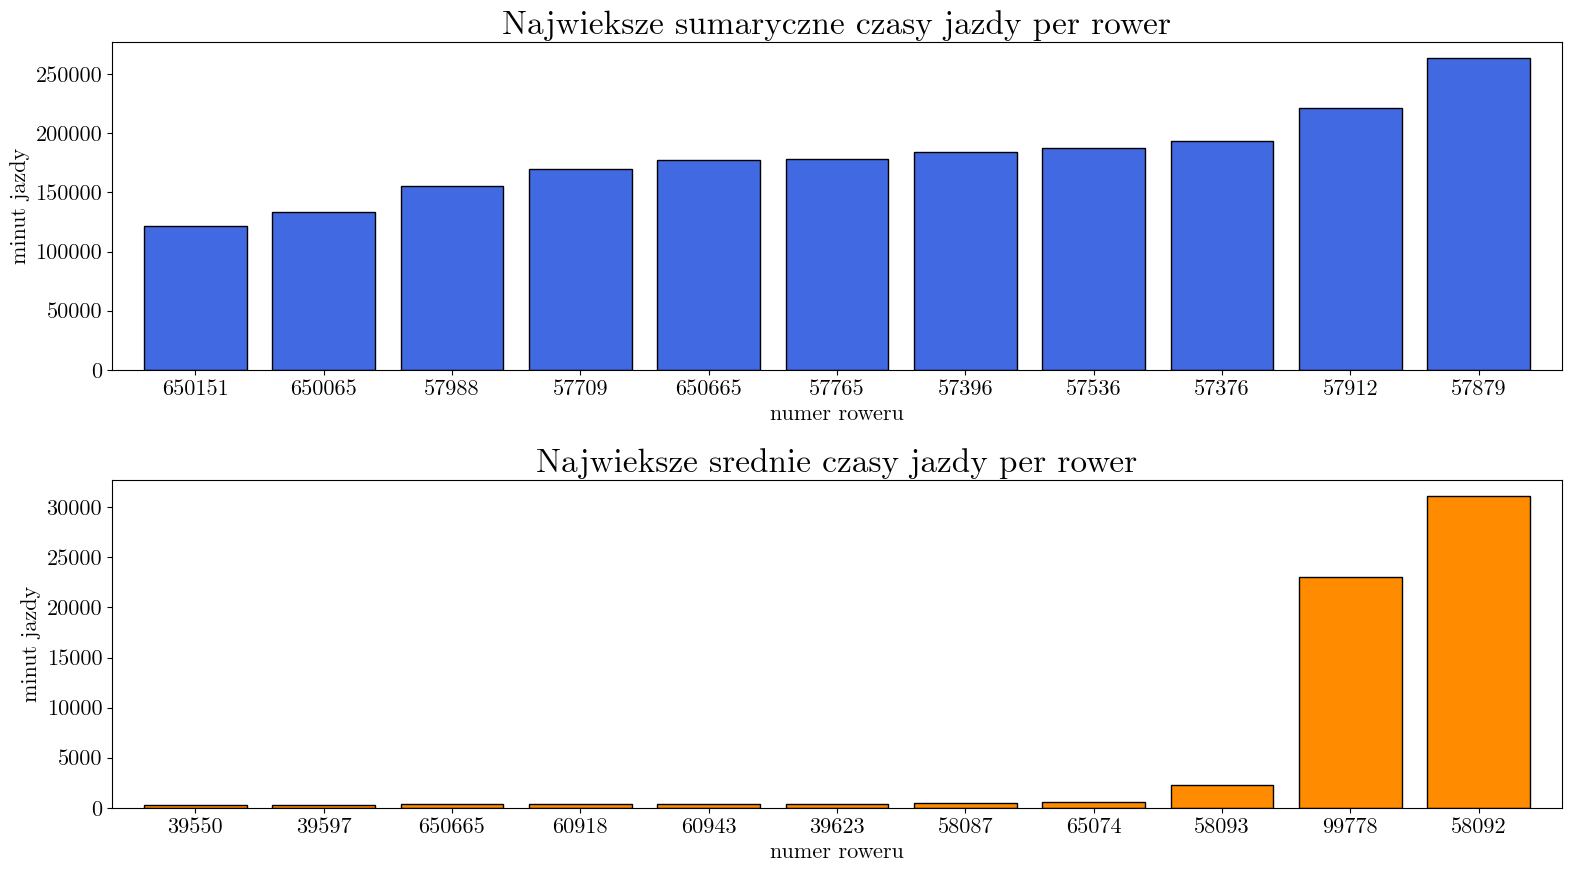

In [11]:
# wykres słupkowy łącznego czasu przejazdu dla 10 z największym czasem
fig, axes = plt.subplots(2, 1, figsize=(16, 9))
bikes_durations_sums.iloc[-11:].plot(
    kind="bar",
    ax=axes[0],
    color="royalblue",
    width=0.8,
    edgecolor="black",
)
bikes_durations_means.iloc[-11:].plot(
    kind="bar", ax=axes[1], color="darkorange", width=0.8, edgecolor="black"
)
axes[0].set_title("Najwieksze sumaryczne czasy jazdy per rower", fontsize=24)
axes[1].set_title("Najwieksze srednie czasy jazdy per rower", fontsize=24)
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("numer roweru")
    ax.set_ylabel("minut jazdy")

plt.tight_layout()
plt.savefig(
    "../images/analysis/srednie_czasy_przejazdu.png",
    bbox_inches="tight",
    dpi=400,
)

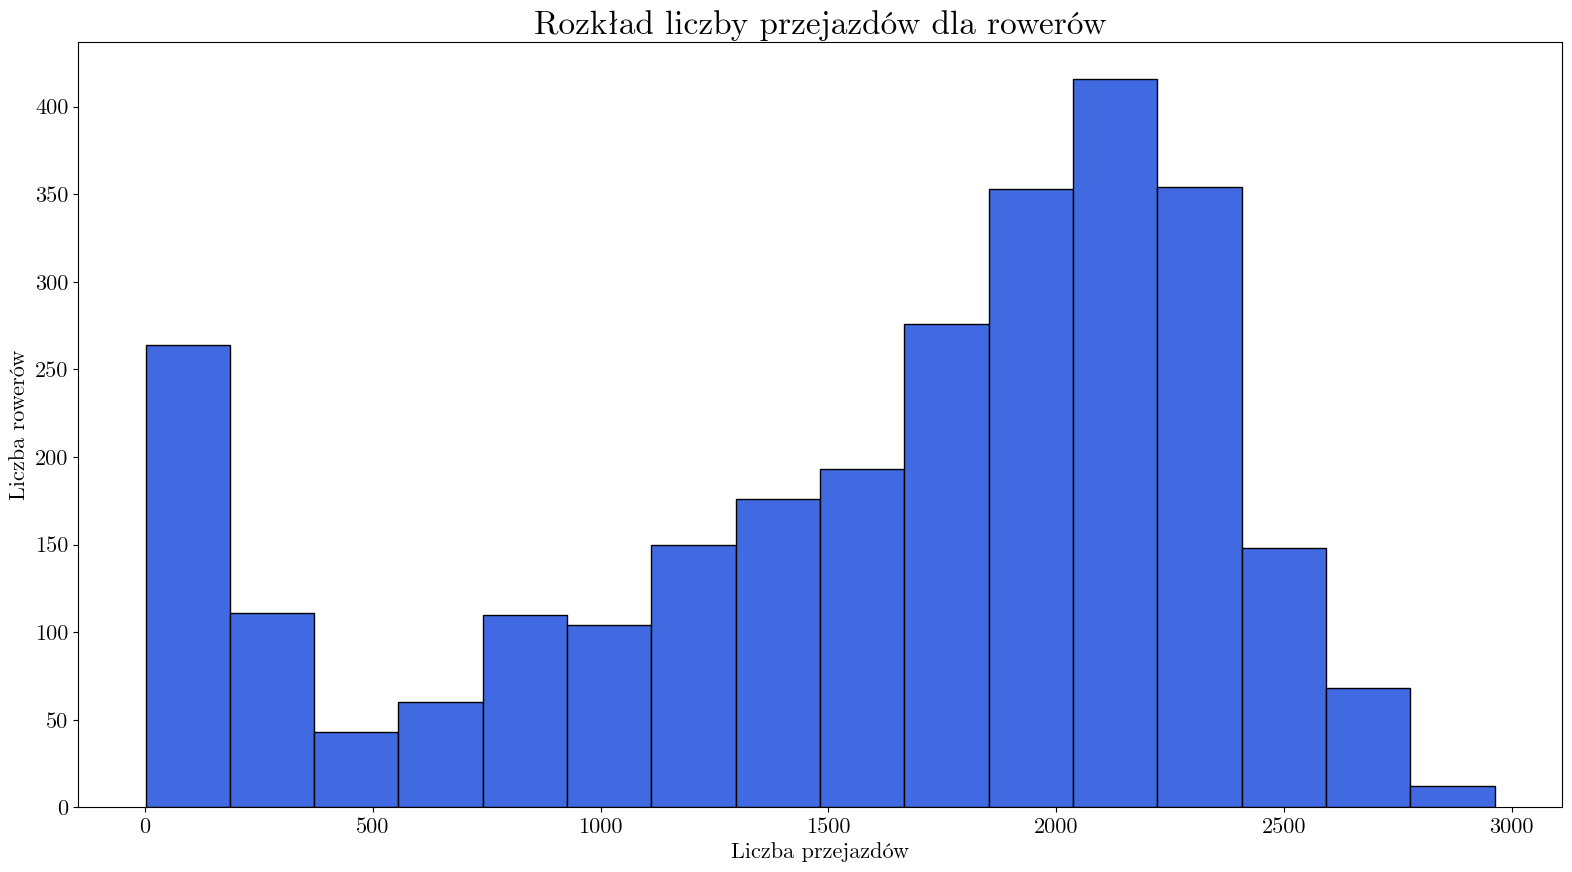

In [12]:
# rozkład liczby przejazdów przez rowery
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(bikes_durations_counts, bins=16, color="royalblue", edgecolor="black")
ax.set_title("Rozkład liczby przejazdów dla rowerów", fontsize=24)
ax.set_xlabel("Liczba przejazdów")
ax.set_ylabel("Liczba rowerów")

plt.tight_layout()
plt.savefig(
    "../images/analysis/liczba_przejazdow.png",
    bbox_inches="tight",
    dpi=400,
)

In [13]:
def get_graph_for_bike(data: pd.DataFrame, bike_number: int) -> nx.Graph:
    """Given data with rides durations, extracts
    rides made with bike with `bike_number` and builds
    graph, where nodes are bike stations
    and edges weights are sums of ride duration
    between given stations
    """
    data_for_bike = data[data["bike_number"] == bike_number]
    edges_series = (
        data_for_bike.drop(columns=["uid"])
        .groupby(["rental_place", "return_place"])["duration"]
        .sum()
    )
    edges_dict = edges_series.to_dict()
    nodes = list(
        set.union(
            set(data_for_bike["rental_place"]), set(data_for_bike["return_place"])
        )
    )
    bike_graph = nx.Graph()
    bike_graph.add_nodes_from(nodes)
    for edge, weight in edges_dict.items():
        source, target = edge
        bike_graph.add_edge(source, target, weight=weight)
    return bike_graph

In [14]:
def draw_bike_graph(G: nx.Graph, pos=None, with_labels=True) -> None:
    fig, ax = plt.subplots(figsize=(6.4 * 2.5, 4.8 * 1.5))
    nx.draw(graph, with_labels=with_labels, ax=ax, pos=pos)
    plt.show()

Wybrane grafy dla rowerów o dużych średnich czasach przejazdu.

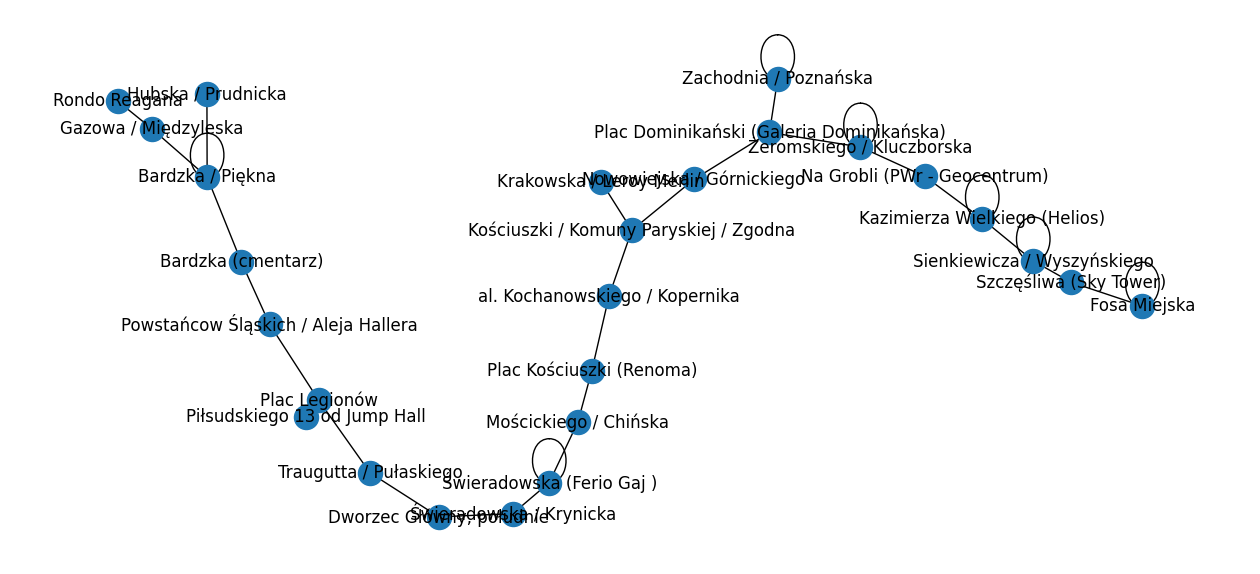

In [15]:
graph = get_graph_for_bike(data=bikes_df, bike_number=651184)
draw_bike_graph(graph)

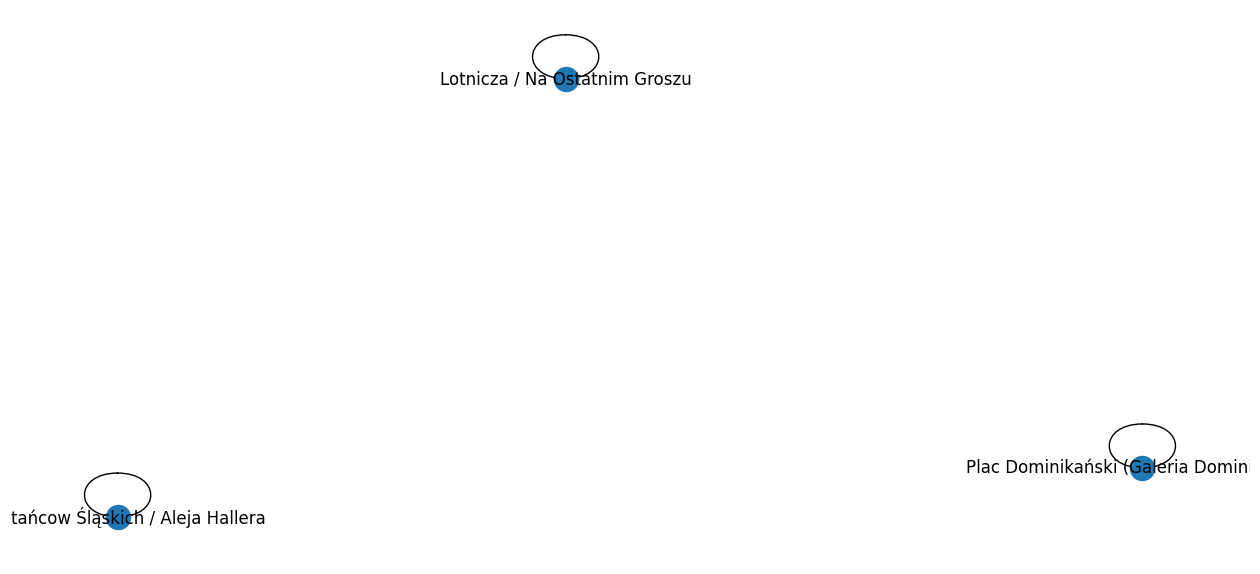

In [16]:
graph = get_graph_for_bike(data=bikes_df, bike_number=58087)
draw_bike_graph(graph)

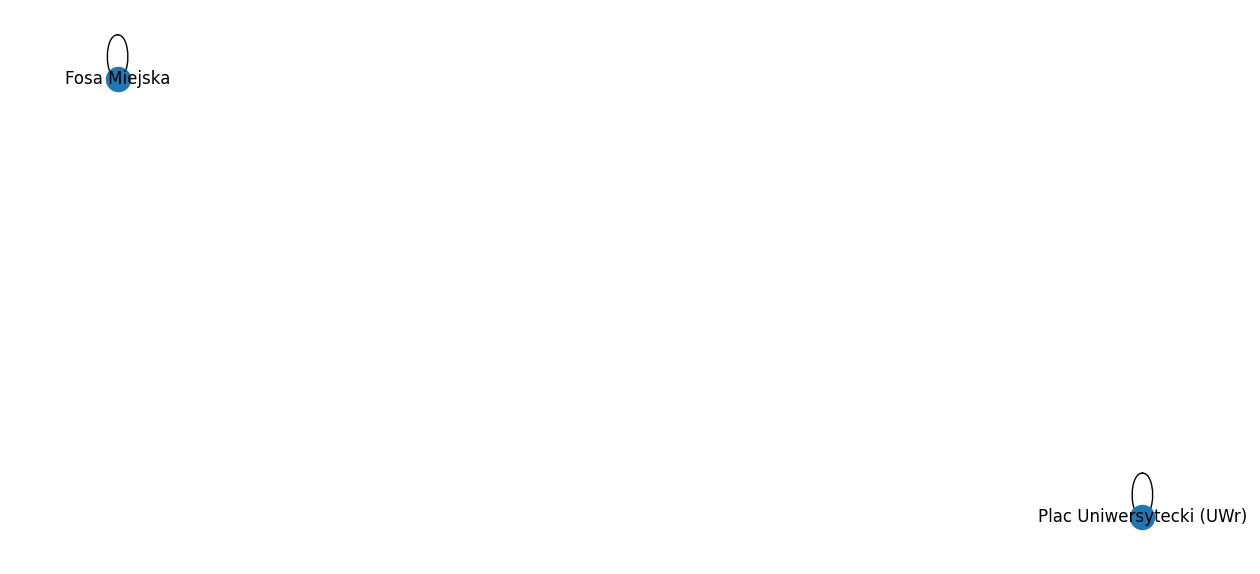

In [17]:
graph = get_graph_for_bike(data=bikes_df, bike_number=bikes_durations_means.index[-10])
draw_bike_graph(graph)

Wybrane grafy dla rowerów o małych średnich czasach przejazdu.

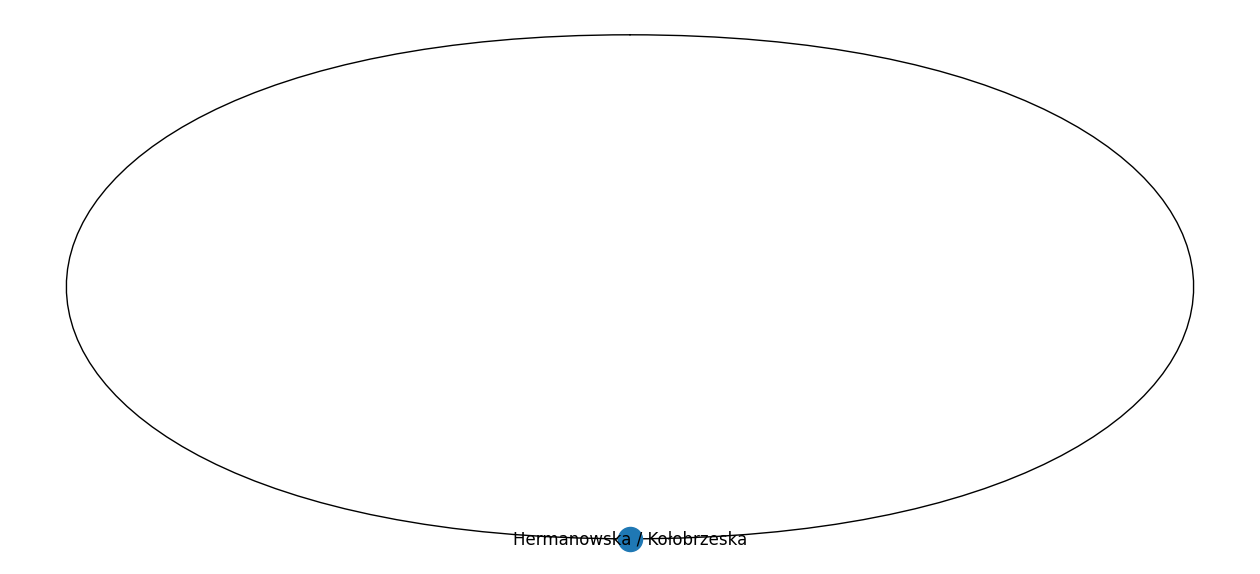

In [18]:
graph = get_graph_for_bike(data=bikes_df, bike_number=bikes_durations_means.index[2])
draw_bike_graph(graph)

Wybrane grafy dla rowerów o dużych sumarycznych czasach przejazdu.

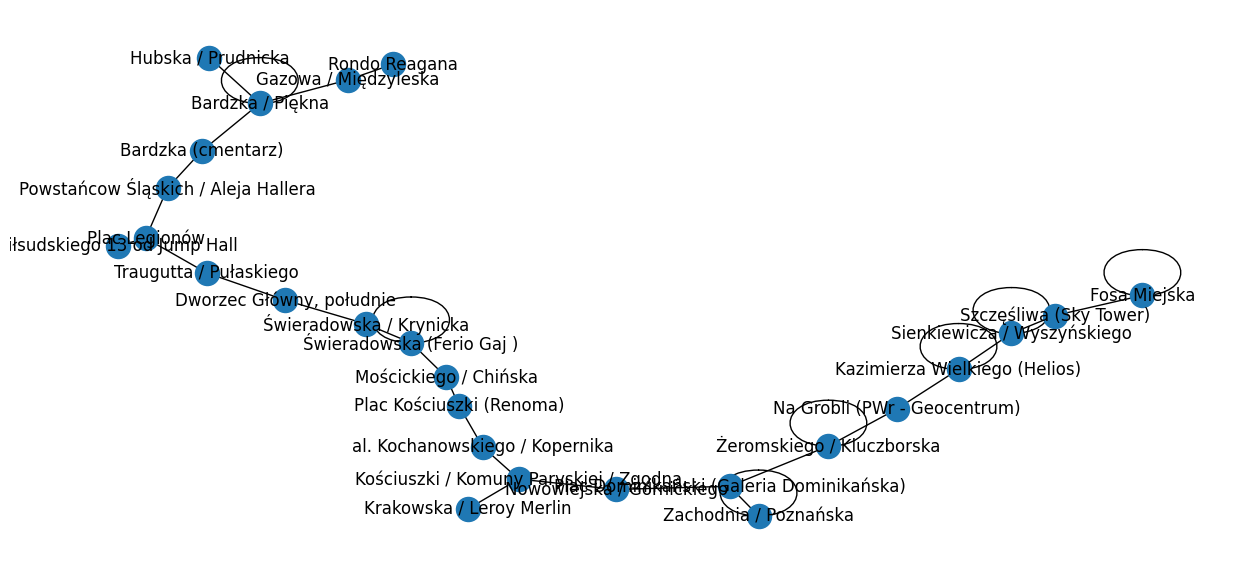

In [19]:
graph = get_graph_for_bike(data=bikes_df, bike_number=651184)
draw_bike_graph(graph)

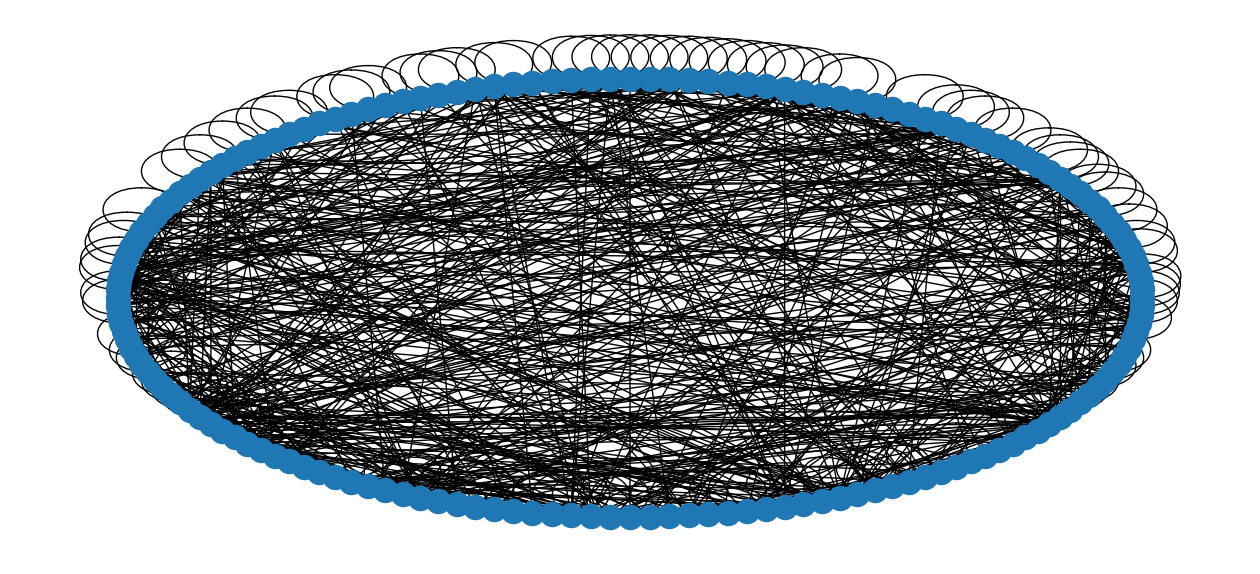

In [20]:
graph = get_graph_for_bike(data=bikes_df, bike_number=57879)
pos = nx.shell_layout(graph)
draw_bike_graph(graph, pos, False)

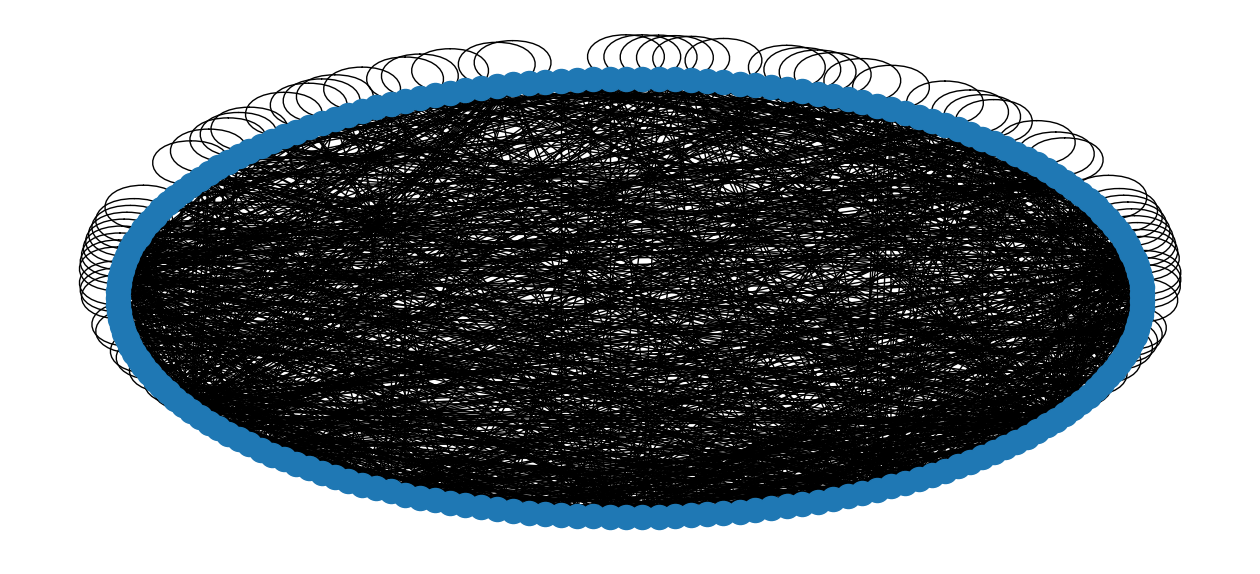

In [21]:
graph = get_graph_for_bike(data=bikes_df, bike_number=57765)
pos = nx.shell_layout(graph)
draw_bike_graph(graph, pos, False)

### Wpływ pór roku na przejazdy

In [6]:
spring_indices = bikes_df.index[
    bikes_df["start_time"].apply(
        lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month in [3, 4, 5]
    )
]
summer_indices = bikes_df.index[
    bikes_df["start_time"].apply(
        lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month in [6, 7, 8]
    )
]
autumn_indices = bikes_df.index[
    bikes_df["start_time"].apply(
        lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month in [9, 10, 11]
    )
]
winter_indices = bikes_df.index[
    bikes_df["start_time"].apply(
        lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month in [12, 1, 2]
    )
]

rides_per_season = {
    "Wiosna": bikes_df.loc[spring_indices],
    "Lato": bikes_df.loc[summer_indices],
    "Jesien": bikes_df.loc[autumn_indices],
    "Zima": bikes_df.loc[winter_indices],
}

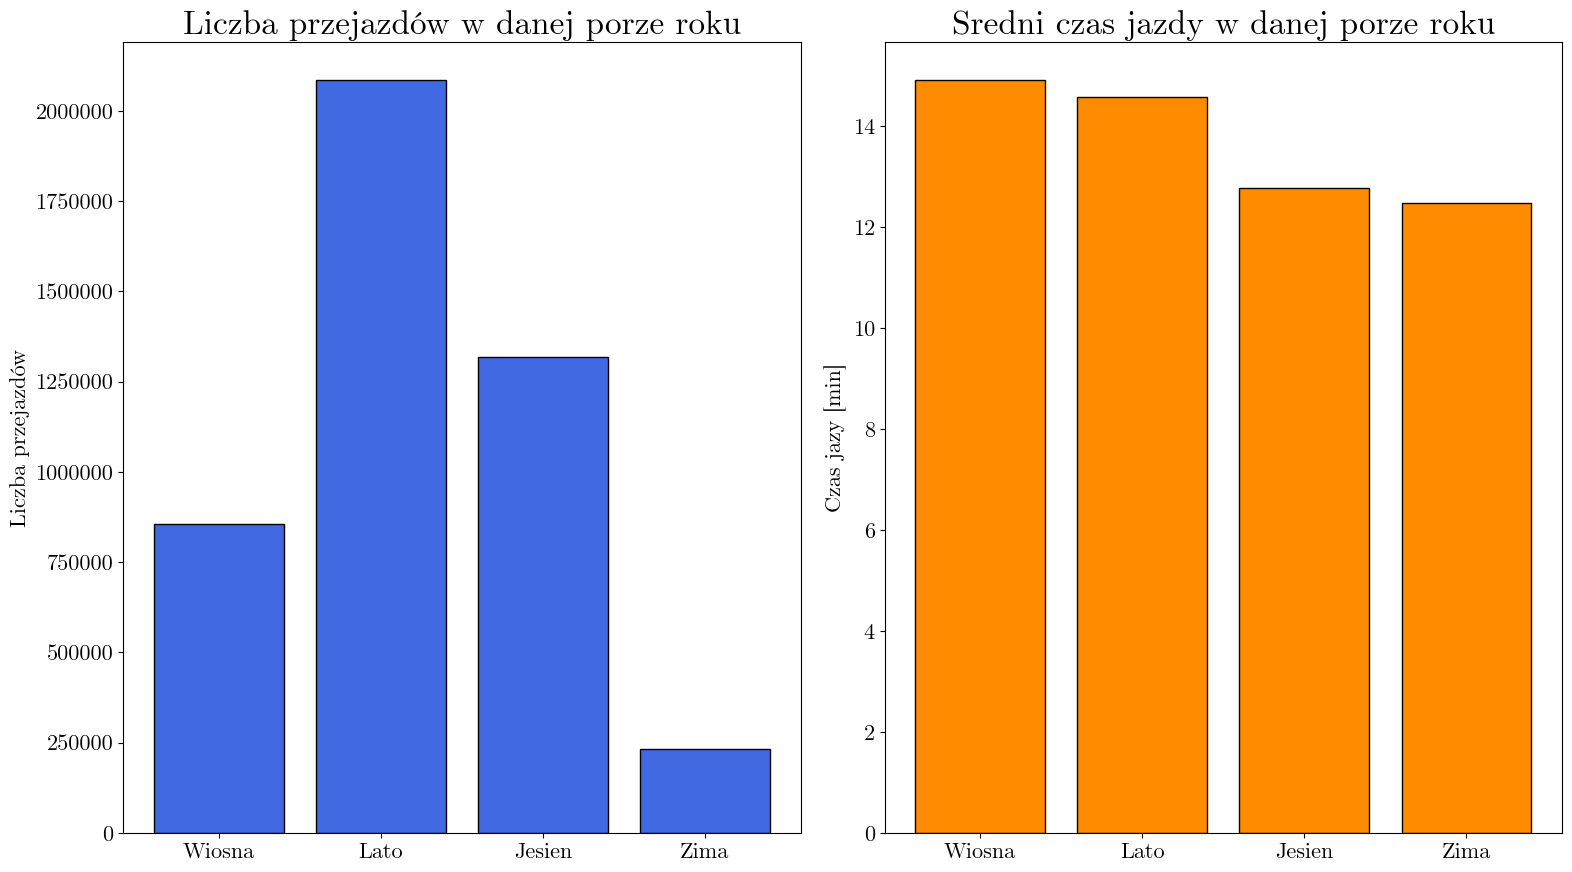

In [7]:
from matplotlib.ticker import ScalarFormatter


fig, ax = plt.subplots(1, 2, figsize=(16, 9))

ax[0].set_title("Liczba przejazdów w danej porze roku", fontsize=24)
ax[0].bar(
    rides_per_season.keys(),
    [len(season) for season in rides_per_season.values()],
    color="royalblue",
    edgecolor="black",
)
ax[0].set_ylabel("Liczba przejazdów")
ax[0].ticklabel_format(axis="y", style="plain", useOffset=False)

ax[1].set_title("Sredni czas jazdy w danej porze roku", fontsize=24)
ax[1].bar(
    rides_per_season.keys(),
    [season['duration'][season['duration'] < 120].mean() for season in rides_per_season.values()],
    color="darkorange",
    edgecolor="black",
)
ax[1].set_ylabel("Czas jazy [min]")

plt.tight_layout()
plt.savefig(
    "../images/analysis/pory_roku.png",
    bbox_inches="tight",
    dpi=400,
)